Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan of to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The loans files are very large (see below), so much time has been spent on cleaning, scrubbing, and casting datatypes. In order to form some initial conclusions, I'll need to sample the entire dataset (45k observations).  

My project goal is to look at the lending club data to form an opinion of the following: 
a) What are the best predictors of borrower default? 
b) What are the best predictors of early borrower repayment? 
c) What rates do borrowers pay versus their other financial options?

Ultimately, I would like to also use complementary external data sources to allow better prediction.  

In [14]:
# load relevant libraries
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns

%matplotlib inline

#import dataset
# This dataset has already benn slightly scrubbed - first line removed, gaps in middle removed
# I  don't know why I need to use 'unicode' to avoid memory error message.  
# Also, check why if header = 1 is used we seem to propogate NaN.
# Check file integrity of original file - noted gaps in the file used, manually correct. 
# lcd_raw = pd.read_csv(url,dtype='unicode')
# Two URLs which can be used:  i) LendingClub_07-12_Approved.csv
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved.csv"
#                              ii) LendingClub_12-13_Approved.csv
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_12-13_Approved.csv"
#                              iii) LendingClub_2014_Approved.csv
url = "/Users/Glenn/Documents/LendingClub/LendingClub_2014_Approved.csv"
lcd_raw = pd.read_csv(url,
            skiprows=1,parse_dates=['last_pymnt_d','issue_d','last_credit_pull_d','last_pymnt_d','next_pymnt_d'])

In [15]:
lcd_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,38098114,40860827,15000,15000,15000,60 months,12.39%,336.64,C,C1,...,0,2015-04-11,336.64,2015-05-11,2015-04-11,674,670,0,NaN,1
1,36805548,39558264,10400,10400,10400,36 months,6.99%,321.08,A,A3,...,0,2015-04-11,321.08,2015-05-11,2015-04-11,694,690,0,59,1
2,37822187,40585251,9600,9600,9600,36 months,13.66%,326.53,C,C3,...,0,2015-04-11,9338.58,NaT,2015-04-11,679,675,0,NaN,1
3,37662224,40425321,7650,7650,7650,36 months,13.66%,260.20,C,C3,...,0,2015-04-11,260.20,2015-05-11,2015-04-11,699,695,0,NaN,1
4,37842129,40605224,21425,21425,21425,60 months,15.59%,516.36,D,D1,...,0,2015-04-11,516.36,2015-05-11,2015-04-11,679,675,0,74,1


In [16]:
# Clean last two lines 
lcd_raw_clean = lcd_raw[:-2]

# lcd_raw_clean.tail()
# lcd_raw_clean.tail()

In [21]:
# Drop certain features we don't need for now, and create a new dataframe 
lcd = lcd_raw_clean.drop(['id','member_id','url', 'desc','title','emp_title','addr_state','zip_code',
                   'funded_amnt_inv','revol_bal','revol_util','out_prncp','out_prncp_inv','total_pymnt',
                   'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','collection_recovery_fee',
                   'last_fico_range_high','last_fico_range_low','initial_list_status','policy_code',
                   'earliest_cr_line','next_pymnt_d','last_credit_pull_d','last_pymnt_d'], axis=1)


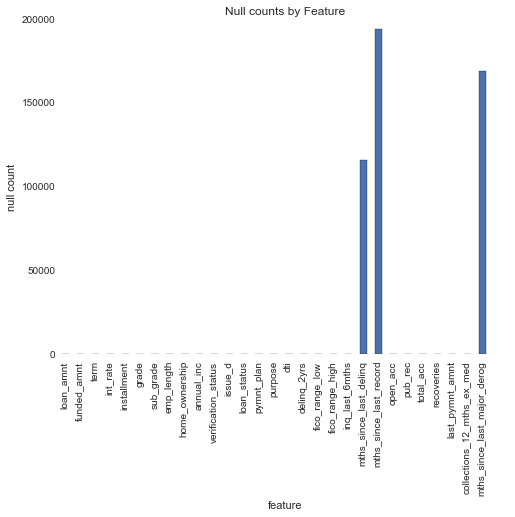

In [22]:
# Plot the isnulls()....

lcd_nulls=[]
features = lcd.columns
x_axis = np.arange(len(lcd.columns))

bar_width =0.5

# Figure out the count of nulls per feature
for r in lcd.columns:
        lcd_nulls.append(lcd[r].isnull().sum())
        
# Make a bar chart
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_axis, lcd_nulls,width=bar_width)
plt.xticks(x_axis+bar_width/2,features,rotation=90)
plt.xlabel('feature')
plt.ylabel('null count')
plt.title('Null counts by Feature')
# plt.show()

Conclusion based on the above graph is that 3 features "mnths_since_last_delinq", "mnths_since_last_record",
mnths_since_last_major_derog contain NaN as a way of transmitting information - specifically
There was no activity for the feature described. 
All the other features have Nan occur sufficiently infrequently that we can assume that it is a data problem and 
Hence can use dropna() is needed.

In [23]:
print lcd.dtypes
# Some data will need to be cleaned. 
print lcd.describe()

loan_amnt                             float64
funded_amnt                           float64
term                                   object
int_rate                               object
installment                           float64
grade                                  object
sub_grade                              object
emp_length                             object
home_ownership                         object
annual_inc                            float64
verification_status                    object
issue_d                        datetime64[ns]
loan_status                            object
pymnt_plan                             object
purpose                                object
dti                                   float64
delinq_2yrs                           float64
fico_range_low                        float64
fico_range_high                       float64
inq_last_6mths                        float64
mths_since_last_delinq                float64
mths_since_last_record            

Axes(0.125,0.125;0.775x0.775)


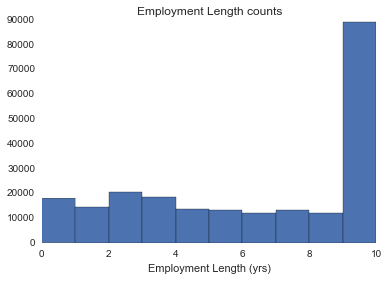

In [24]:
#lcd.emp_length.unique()
#array(['10+ years', , '1 year', '3 years', '8 years', '9 years',
#        '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)
lcd['emp_length_numeric'] = lcd['emp_length'].map({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, 
                                                  '4 years':4,'5 years':5,'6 years':6,'7 years':7,
                                                  '8 years':8,'9 years':9,'10+ years':10})

print lcd['emp_length_numeric'].hist()
plt.title('Employment Length counts')
plt.xlabel('Employment Length (yrs)')

In [36]:
plt_data.head()
plt_data_a = plt_data[plt_data['grade']=='A']
# plt_data_a.head()

Employment length reasonably evenly distributed out to 5 years.    How is this distributed versus FICO score?

In [9]:
# clean term by splitting on spaces and converting numbers into float
lcd.term.fillna(method='backfill',inplace = True)
lcd.term.isnull().sum()
lcd.term.unique()
lcd['clean_term'] = [float (s.split(' ')[1]) for s in lcd.term]


lcd['clean_term'].describe()

count    235629.000000
mean         43.441427
std          11.100448
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: clean_term, dtype: float64

In [51]:
# Create a plot of lending rate vs time for eacth rating
# First cut - look at all loan rate over time for all loans rated 'A'
# Create a dataframe which uses issue date column as an index

lcd.grade.unique()
lcd.head()
pl
# plt_data = pd.DataFrame(lcd['grade','term','int_rate'],index = lcd.issue_d,columns=['grade','term','int_rate'])
plt_data = [lcd.grade,lcd.term,lcd.int_rate]
plt_data= lcd.set_index('issue_d')
plt_data.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,recoveries,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,emp_length_numeric
issue_d,,,,,,,,,,,,,,,,,,,,,
2014-12-11,15000,15000,60 months,12.39%,336.64,C,C1,10+ years,RENT,78000,...,NaN,NaN,6,0,17,0,336.64,0,NaN,10
2014-12-11,10400,10400,36 months,6.99%,321.08,A,A3,8 years,MORTGAGE,58000,...,42,NaN,17,0,36,0,321.08,0,59,8
2014-12-11,9600,9600,36 months,13.66%,326.53,C,C3,10+ years,RENT,69000,...,NaN,NaN,12,0,44,0,9338.58,0,NaN,10
2014-12-11,7650,7650,36 months,13.66%,260.20,C,C3,< 1 year,RENT,50000,...,NaN,NaN,11,0,20,0,260.20,0,NaN,0
2014-12-11,21425,21425,60 months,15.59%,516.36,D,D1,6 years,RENT,63800,...,60,NaN,10,0,35,0,516.36,0,74,6


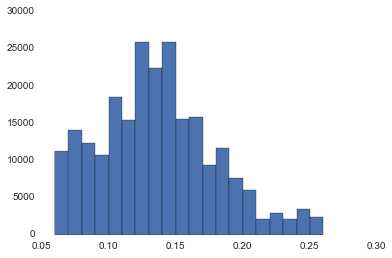

In [10]:
# Strip chars, convert int_rate series to float
lcd.int_rate.fillna(method='backfill',inplace = True)

lcd['clean_rates'] = [float(t.strip(' %'))/100 for t in lcd.int_rate]

lcd['clean_rates'].hist(bins=20)

([<matplotlib.axis.XTick at 0x109ca8310>,
 <a list of 35 Text xticklabel objects>)

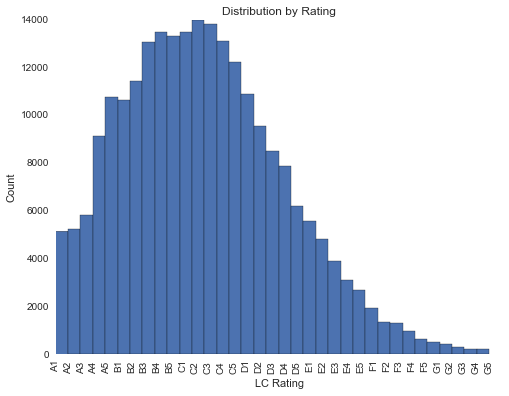

In [11]:
# print lcd['sub_grade'].unique()
#['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
# 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5' 'G4' 'E2'
# 'G3' 'G2' 'G1' 'F5' 'G5']

lcd['sub_grade_int']=lcd['sub_grade'].map({'A1':0,'A2':1,'A3':2,'A4':3,'A5':4,
                                           'B1':5,'B2':6,'B3':7,'B4':8,'B5':9,
                                           'C1':10,'C2':11,'C3':12,'C4':13,'C5':14,
                                           'D1':15,'D2':16,'D3':17,'D4':18,'D5':19,
                                           'E1':20,'E2':21,'E3':22,'E4':23,'E5':24,
                                           'F1':25,'F2':26,'F3':27,'F4':28,'F5':29,
                                           'G1':30,'G2':31,'G3':32,'G4':33,'G5':34})

plt.figure(figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
lcd['sub_grade_int'].hist(bins=35)

plt.xlabel('LC Rating')
plt.ylabel('Count')
plt.title('Distribution by Rating')
X_Axis_Labels = ('A1','A2','A3','A4','A5','B1','B2','B3','B4','B5',
                 'C1','C2','C3','C4','C5','D1','D2','D3','D4','D5',
                 'E1','E2','E3','E4','E5','F1','F2','F3','F4','F5',
                 'G1','G2','G3','G4','G5')
x_axis = np.arange(len(X_Axis_Labels))

plt.xticks(x_axis,X_Axis_Labels,rotation=90)                             

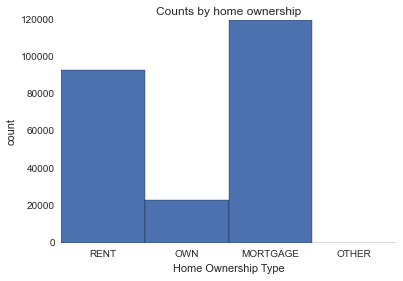

In [12]:
# print lcd['home_ownership'].unique()
# ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']

# Map ownership type to categorical variable
lcd['home_ownership_int'] = lcd['home_ownership'].map({'RENT':0, 'OWN':1, 'MORTGAGE':2, 'OTHER':3, 'NONE':4})
lcd['rent']= lcd['home_ownership_int']==0
lcd['own']= lcd['home_ownership_int']==1
lcd['mort']= lcd['home_ownership_int']==2
lcd['other']=lcd['home_ownership_int']==3

# lcd['home_ownership_int'].hist(figsize=(8, 6),bins=4)
bar_width = 1.0
x_axis = np.linspace(0,3,num=4)
plt.bar(x_axis,(lcd['rent'].sum(),lcd['own'].sum(),lcd['mort'].sum(),lcd['other'].sum()),width=bar_width)
plt.xticks(x_axis+bar_width/2,('RENT', 'OWN', 'MORTGAGE', 'OTHER'))
plt.xlabel('Home Ownership Type')
plt.ylabel('count')
plt.title('Counts by home ownership')

In [13]:
# print lcd['is_inc_v'].unique()
# ['Verified' 'Source Verified' 'Not Verified']
lcd['is_inc_v_bool']= (lcd['is_inc_v']== 'Verified') | (lcd['is_inc_v'] =='Source Verified')

KeyError: 'is_inc_v'

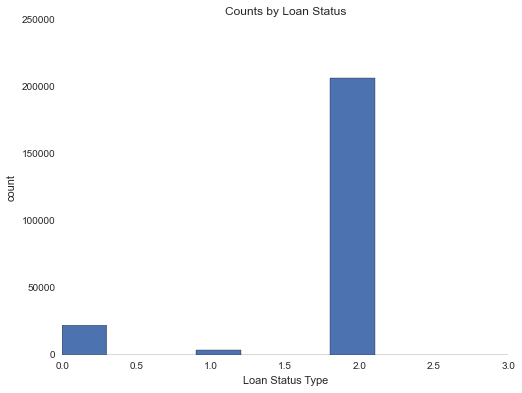

In [14]:
# print lcd['loan_status'].unique()
# ['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
#  'In Grace Period' 'Late (16-30 days)'
# 'Does not meet the credit policy.  Status:Current'
# 'Does not meet the credit policy.  Status:Charged Off'
# 'Does not meet the credit policy.  Status:Fully Paid'
# 'Does not meet the credit policy.  Status:Late (16-30 days)'
# 'Does not meet the credit policy.  Status:In Grace Period'
# 'Does not meet the credit policy.  Status:Late (31-120 days)']

# This will become our Response variable (y)

# Create a calculated feature which simplifies the accounting.   
# Fold anything <30 days delinquent into current
# Fold any other delinquency not defaulted into delinquent
# Fold 'Does not meet the Credit Policy' into similar category for other loans
# 0 = Fully paid
# 1 = Charged off
# 2 = Current
# 3 = Default
# 4 = Late

lcd['loan_status_int']=lcd['loan_status'].map({'Fully Paid':0,'Charged Off':1,'Current':2,'Default':3,
                            'Late (31-120days)':4,'In Grace Period':2,'Late (16-30 days)':2,
                            'Does not meet the credit policy.  Status:Current':2,
                            'Does not meet the credit policy.  Status:Charged Off':1,
                            'Does not meet the credit policy.  Status:Fully Paid':0,
                            'Does not meet the credit policy.  Status:Late (16-30 days)':2,
                            'Does not meet the credit policy.  Status:In Grace Period':0,
                            'Does not meet the credit policy.  Status:Late (31-120 days)':2})                     
                           
lcd['loan_status_int'].hist(figsize=(8, 6))
lcd['default']=lcd['loan_status_int']==3
plt.xlabel('Loan Status Type')
plt.ylabel('count')
plt.title('Counts by Loan Status')

In [15]:
lcd['default'].sum()

73

In [21]:
# print lcd['pymnt_plan'].unique()
# ['n' 'y']

# Set up calculated feature which is boolean
lcd['pymnt_plan_bool']= (lcd['pymnt_plan']=='y').astype(bool)

In [22]:
# print lcd['purpose'].unique() 
# ['credit_card' 'car' 'small_business' 'other' 'wedding'
#  'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
#  'moving' 'vacation' 'house' 'renewable_energy' 'educational']


Index([u'loan_amnt', u'funded_amnt', u'term', u'int_rate', u'installment', u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc', u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan', u'purpose', u'dti', u'delinq_2yrs', u'fico_range_low', u'fico_range_high', u'inq_last_6mths', u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc', u'pub_rec', u'total_acc', u'recoveries', u'last_pymnt_amnt', u'collections_12_mths_ex_med', u'mths_since_last_major_derog', u'emp_length_numeric', u'clean_term', u'clean_rates', u'sub_grade_int', u'home_ownership_int', u'rent', u'own', u'mort', u'other', u'loan_status_int', u'default', u'pymnt_plan_bool', u'fico_interp'], dtype='object')

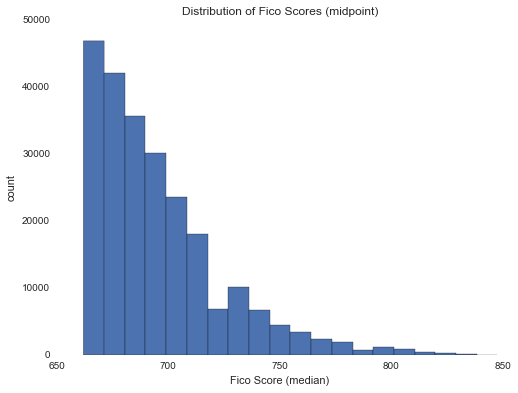

In [23]:
# Introduce calculated features
lcd['fico_interp']=(lcd['fico_range_low']+lcd['fico_range_high'])/2

lcd['fico_interp'].hist(bins=20,figsize=(8, 6))
plt.xlabel('Fico Score (median)')
plt.ylabel('count')
plt.title('Distribution of Fico Scores (midpoint)')

lcd.columns

In [24]:
#  USE LEARNING CURVES TO FIND THE OPTIMAL SAMPLE SIZE TRAIN VS TEST DIm REduction Sample Size Reduction
#  SKLearn, feature selection - Feature
#  SkLean.Learning Curves - Sample Size
# Now lets  sample a small percentage of the data, say 5%
# convert lcd into array.  

lcd_sample1,lcd_sample2 = train_test_split(pd.DataFrame.as_matrix(lcd),test_size=0.05,random_state=123) 

#now convert the 'train' data back into a dataframe
lcd_small = pd.DataFrame(lcd_sample2,columns=lcd.columns)

lcd_small.columns

Index([u'loan_amnt', u'funded_amnt', u'term', u'int_rate', u'installment', u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc', u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan', u'purpose', u'dti', u'delinq_2yrs', u'fico_range_low', u'fico_range_high', u'inq_last_6mths', u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc', u'pub_rec', u'total_acc', u'recoveries', u'last_pymnt_amnt', u'collections_12_mths_ex_med', u'mths_since_last_major_derog', u'emp_length_numeric', u'clean_term', u'clean_rates', u'sub_grade_int', u'home_ownership_int', u'rent', u'own', u'mort', u'other', u'loan_status_int', u'default', u'pymnt_plan_bool', u'fico_interp'], dtype='object')

In [20]:
lcd.columns

Index([u'loan_amnt', u'funded_amnt', u'term', u'int_rate', u'installment', u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc', u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan', u'purpose', u'dti', u'delinq_2yrs', u'fico_range_low', u'fico_range_high', u'inq_last_6mths', u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc', u'pub_rec', u'total_acc', u'recoveries', u'last_pymnt_amnt', u'collections_12_mths_ex_med', u'mths_since_last_major_derog', u'emp_length_numeric', u'clean_term', u'clean_rates', u'sub_grade_int', u'home_ownership_int', u'rent', u'own', u'mort', u'other', u'loan_status_int', u'default'], dtype='object')

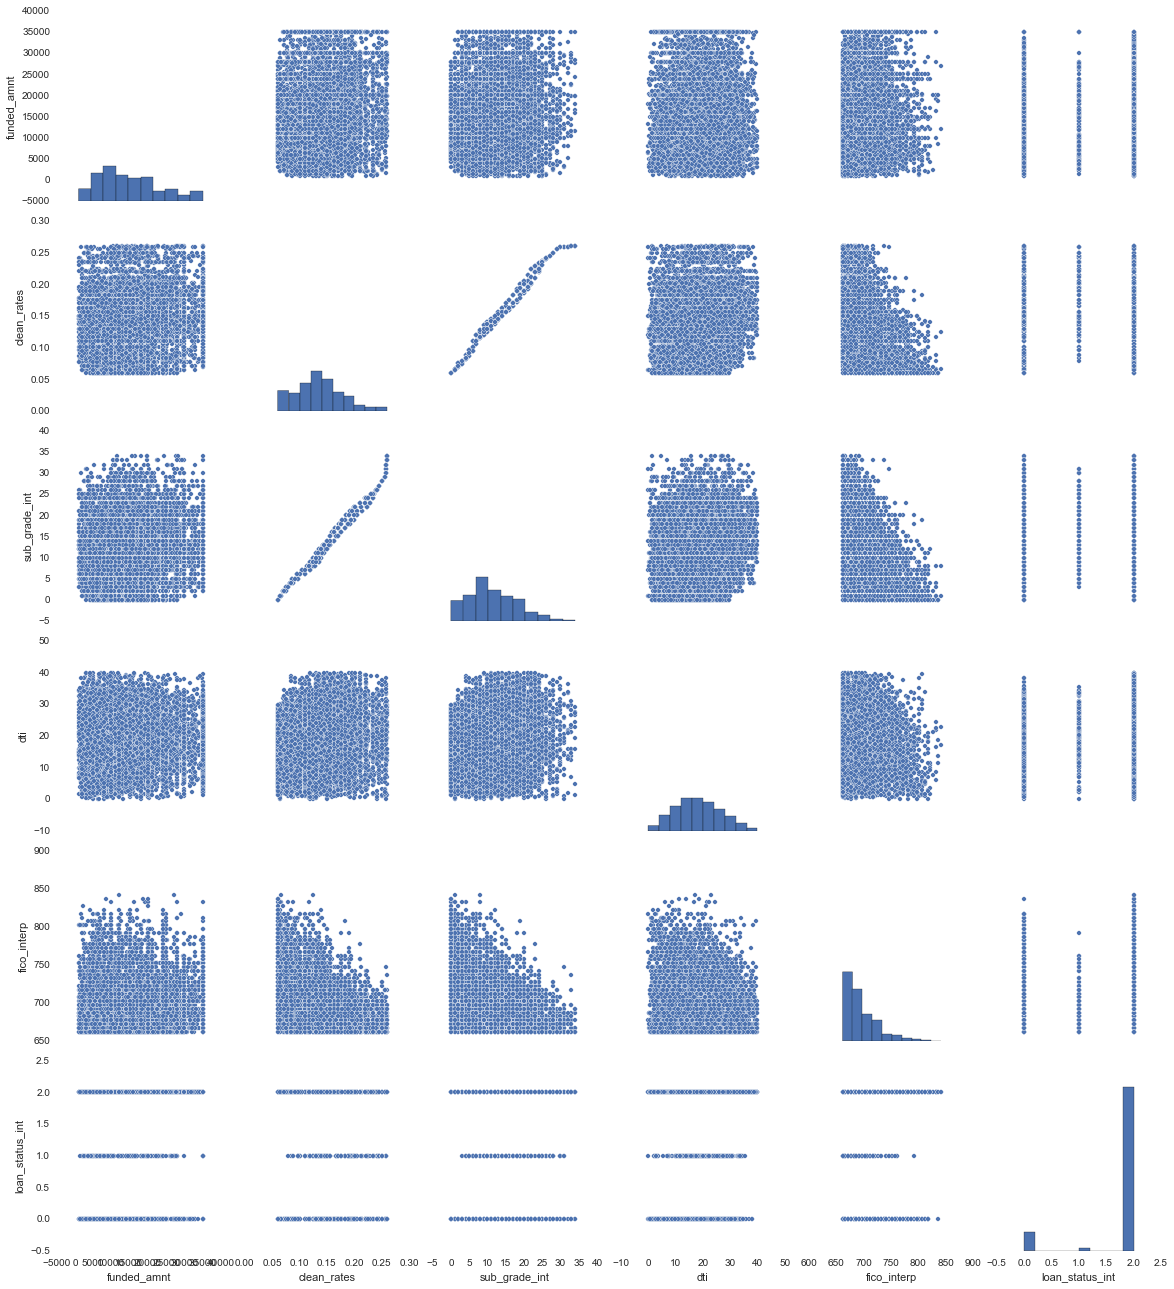

In [25]:
# Scatter plot a subset of certain selected features.  
cols = ['loan_amnt', 'funded_amnt','int_rate']

# pd scatter_matrix doesn't work, but sns does.... why? 
# pd.scatter_matrix(lcd_small[['loan_amnt', 'funded_amnt','int_rate']], figsize=(18, 18), alpha=0.05, diagonal='kde')
sns.pairplot(data=lcd_small[['funded_amnt','clean_rates','sub_grade_int','home_ownership',
                          'dti','fico_interp','loan_status_int']], aspect=0.90, dropna=True)

    
# sns.corrplot(data=lcd_small[['funded_amnt','clean_rates','sub_grade_int','emp_length_numeric','home_ownership',
#                        'is_inc_v','dti','fico_interp','loan_status_int']])